# Machine Learning and Data Analysis for Business and Finance 
# Final Project: Boston Airbnb Revenue Prediction
**Yuzhou Liu, Hang Xu, Leiyuxiang Wu, Jiaren Ma**

## Introduction

The goal of this project is to identify factors contributing to popular Airbnb listings in Boston and provide hosts with guidance on how to lift revenue by manipulating key contributing factors. We combine external data like text reviews, distance to Boston attractions and crime rate by neighborhood with Boston Airbnb listing data, applying typical models such as KNN, Ridge/Lasso,Kernel Ridge, Boosting Tree and Random Forest to find which of those variables best interpret the popularity of the given properties. Then we can use relationships between factors and properties popularity to help hosts boost their revenue. 

## Package Used

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_feature_importances(model):
    n_features = Features.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), Features_df.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

## Datasets & Preprocesing

The main dataset investigated here is Boston airbnb listing data from **Inside Airbnb** webiste plus text reviews data, distance to Boston Attraction and crime rate by neighborhood. The airbnb lisitng data include features of about 6000 current airbnb listings around great boston area on 09/14/2018. The raw dataset contains daily price, cleaning fee, security deposite and other 27 variables. 

The target variable of our interests is availability_90, which is the historical average 90-day availability (number of days). As mentioned before, one of our aims is to perdict monthly revenues for airbnb owners, and the availability_90 data contains the average monthly occupation, which can convert to monthly revenue multiplying by daily price.

For **availability_90**, we converted it to average occupancy in 90 (OCC) days for revenue prediction by simply deducting from 90. Thus, as mentioned before, it can be easily converted to monthly revenue multiplying by daily price/3.

Moreover, we did some modification and transformation such as log transformation and drop N/A records to clean the dataset. We also converted categorical variables to dummy variables and scale all variables so as to satisfy some model assumptions.


In [3]:
airbnb = pd.read_csv('../Data/Airbnb.csv', index_col = 0)
ResponseTimeDummy= pd.get_dummies(airbnb['host_response_time'],drop_first=True)
RoomTypeDummy = pd.get_dummies(airbnb['room_type'],drop_first=True)
PropTypeDummy = pd.get_dummies(airbnb['property_type'],drop_first=True)
frame = [airbnb,ResponseTimeDummy,RoomTypeDummy,PropTypeDummy]
airbnb = pd.concat(frame, join="inner", axis=1)
Target = airbnb.OCC
Features_df = airbnb.drop(['OCC', 'host_response_time','room_type', 'property_type'], axis=1)

#### Scaling down

In [4]:
scaler = StandardScaler()
scaler.fit(Features_df)
Features = scaler.transform(Features_df)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


## KNN as Benchmark
#### Determine Proper K value

Since K-Nearest Neighbor has a special advantage of “no assumptions required” as well as “easy to understand”, we decide to adopt this method in our research as Benchmark model. 

The overall process for all our models are similar. First, we use a for loop to find the optimal parameter value in KNN cases is the number of “n”. Judging from the plot output, we find that the number of around 8 will be a good fit since the accuracy of training set and test set are close while overfitting is got rid of.

Then, we run the cross validation (different train/test data splits) 15 times to better wipe out the randomness of the regression result and get the score for modle performance.

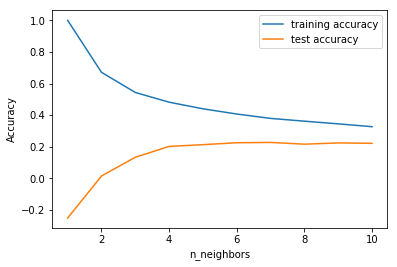

In [12]:
training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 11)
X_train, X_test, y_train, y_test = train_test_split(Features, Target, test_size = 0.2)

for n_neighbors in neighbors_settings:
    # build the model
    clf = KNeighborsRegressor(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))
    
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

#### Cross Validation
We see that the mean training score accuracy approximates 0.374 and the mean test score accuracy approaches 0.180.

In [11]:
n = 15
reg = KNeighborsRegressor(n_neighbors=8)
KNNTrainScore = np.zeros(n)
KNNTestScore = np.zeros(n)
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(Features, Target, test_size = 0.2)
    reg.fit(X_train,y_train)
    KNNTrainScore = reg.score(X_train,y_train)
    KNNTestScore = reg.score(X_test,y_test)
print('K-Nearest Neighbour Train Score is {}'.format(KNNTrainScore.mean()))
print('K-Nearest Neighbour Test Score is {}'.format(KNNTestScore.mean()))

K-Nearest Neighbour Train Score is 0.3745826054526281
K-Nearest Neighbour Test Score is 0.18002205425136086


## Ridge Regression
#### Grid Search

In [23]:
score_used = 'r2'
param_grid={'alpha':[0.001,0.01,0.1,1,10,50,100,200,300,400,500,600,700,800,900,1000]}
shuffle_split = ShuffleSplit(test_size=0.2, train_size=0.8, n_splits=15)
grid_search=GridSearchCV(Ridge(),param_grid,cv=shuffle_split,scoring=score_used, 
                              return_train_score=True)
grid_search.fit(Features,Target)
results = pd.DataFrame(grid_search.cv_results_)
print(results[['rank_test_score','mean_test_score','mean_train_score','param_alpha']])

    rank_test_score  mean_test_score  mean_train_score param_alpha
0                 8         0.192743          0.208192       0.001
1                 7         0.192743          0.208192        0.01
2                 6         0.192748          0.208192         0.1
3                 5         0.192797          0.208192           1
4                 4         0.193131          0.208171          10
5                 2         0.193662          0.207992          50
6                 1         0.193807          0.207641         100
7                 3         0.193439          0.206557         200
8                 9         0.192550          0.205110         300
9                10         0.191339          0.203432         400
10               11         0.189918          0.201608         500
11               12         0.188359          0.199693         600
12               13         0.186709          0.197724         700
13               14         0.185001          0.195728        

#### Cross Validation

In [22]:
n = 15
ridge = Ridge(alpha = 100)
ridgeTrainScore = np.zeros(n)
ridgeTestScore = np.zeros(n)
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(Features, Target, test_size = 0.2)
    ridge.fit(X_train,y_train)
    ridgeTrainScore = ridge.score(X_train,y_train)
    ridgeTestScore = ridge.score(X_test,y_test)
print('Ridge Train Score is {}'.format(ridgeTrainScore.mean()))
print('Ridge Test Score is {}'.format(ridgeTestScore.mean()))

Ridge Train Score is 0.20928762949902466
Ridge Test Score is 0.18177406383409755


## Lasso Regression
#### Grid Search

In [28]:
score_used = 'r2'
param_grid={'alpha':[0.001,0.01,0.05,0.08,0.1,1,10,100]}
shuffle_split = ShuffleSplit(test_size=0.2, train_size=0.8, n_splits=15)
grid_search=GridSearchCV(Lasso(),param_grid,cv=shuffle_split,scoring=score_used, 
                              return_train_score=True)
grid_search.fit(Features,Target)
results = pd.DataFrame(grid_search.cv_results_)
print(results[['rank_test_score','mean_test_score','mean_train_score','param_alpha']])

   rank_test_score  mean_test_score  mean_train_score param_alpha
0                5         0.187493          0.209327       0.001
1                4         0.188004          0.209299        0.01
2                3         0.189236          0.209075        0.05
3                2         0.189815          0.208822        0.08
4                1         0.190035          0.208629         0.1
5                6         0.174666          0.182046           1
6                7         0.026774          0.028852          10
7                8        -0.001015          0.000000         100


#### Cross Validation

In [20]:
n = 15
lasso = Lasso(alpha = 0.1)
lTrainScore = np.zeros(n)
lTestScore = np.zeros(n)
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(Features, Target, test_size = 0.2)
    lasso.fit(X_train,y_train)
    lTrainScore = ridge.score(X_train,y_train)
    lTestScore = ridge.score(X_test,y_test)
print('Lasso Train Score is {}'.format(lTrainScore.mean()))
print('Lasso Test Score is {}'.format(lTestScore.mean()))

Lasso Train Score is 0.20670583136969523
Lasso Test Score is 0.19954809391830128


The results from Ridge and Lasso regressions show little improvement from our benchmark KNN model, whihc indicates that the relationship of Features and airbnb occupancy is not linear. Therefore, we tried kernel ridge and tree based model latter.

## Kernel Ridge
#### Grid Search

In [ ]:
score_used = 'r2'
param_grid={"alpha": np.linspace(1,3,11),"gamma": np.linspace(0.01,0.1,11),'kernel':['rbf']}
shuffle_split = ShuffleSplit(test_size=0.2, train_size=0.8, n_splits=15)
grid_search=GridSearchCV(KernelRidge(),param_grid,cv=shuffle_split,scoring=score_used, 
                              return_train_score=True)

kernel_Ridge=grid_search.fit(Features,Target)
KRcvResult = pd.DataFrame(kernel_Ridge.cv_results_)

In [5]:
KRcvResult = pd.read_excel('../Data/KRcvResult.xlsx', sheet_name = 'Grid_Search')
print(KRcvResult[['rank_test_score','mean_test_score','mean_train_score','param_alpha','param_gamma','param_kernel']])

     rank_test_score  mean_test_score  mean_train_score  param_alpha  \
0                  3         0.227616          0.326363          1.0   
1                  1         0.230205          0.391882          1.0   
2                  7         0.223749          0.443405          1.0   
3                 26         0.209822          0.484340          1.0   
4                 39         0.189537          0.516697          1.0   
5                 50         0.163795          0.542055          1.0   
6                 61         0.133286          0.561636          1.0   
7                 72         0.098562          0.576389          1.0   
8                 83         0.060109          0.587075          1.0   
9                 92         0.018375          0.594312          1.0   
10               102        -0.026229          0.598609          1.0   
11                 4         0.225752          0.317011          1.2   
12                 2         0.227832          0.377569         

In [7]:
B_Paremeter=KRcvResult.loc[KRcvResult['rank_test_score']==1]
B_Paremeter=B_Paremeter.iloc[:,[4,5,23,41]]
print(B_Paremeter)

   param_alpha  param_gamma  mean_test_score  mean_train_score
1          1.0        0.019         0.230205          0.391882


In [24]:
n = 15
KR = KernelRidge(alpha=1.,gamma=0.019,kernel='rbf')
KRTrainScore = np.zeros(n)
KRTestScore = np.zeros(n)
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(Features, Target, test_size = 0.2)
    KR.fit(X_train,y_train)
    KRTrainScore = KR.score(X_train,y_train)
    KRTestScore = KR.score(X_test,y_test)
print('KernelRidge Train Score is {}'.format(KRTrainScore.mean()))
print('KernelRidge Test Score is {}'.format(KRTestScore.mean()))

KernelRidge Train Score is 0.38444126523588773
KernelRidge Test Score is 0.23340335219362562


The best Kernel Ridge regression gives us 0.23 mean_test_score, which is slightly higher than the Linear Regression method but still doesn't meet our expectation.The reason may be that we have many categorical predictors in our dataset, which may be poor indicators as the distance between two points，which are calculated in Kernel Function, doesn't represent any meaningful result. Therefore, we think the tree-type model,combining with bagging technique, would be the appropriate one to our dataset.

## Boost Tree

#### Grid Search

In [30]:
score_used = 'r2'
param_grid={'learning_rate':[0.05,0.1,0.15,0.2],'max_depth':[5,10,15,20]}
shuffle_split = ShuffleSplit(test_size=0.2, train_size=0.8, n_splits=15)
grid_search=GridSearchCV(GradientBoostingRegressor(n_estimators=100),param_grid,cv=shuffle_split,scoring=score_used, 
                              return_train_score=True)
grid_search.fit(Features,Target)
BTcvResult = pd.DataFrame(grid_search.cv_results_)

In [6]:
BTcvResult = pd.read_csv('../Data/BTcvResult.csv',index_col=0)
print(BTcvResult[['rank_test_score','mean_test_score','mean_train_score','param_learning_rate','param_max_depth']])

    rank_test_score  mean_test_score  mean_train_score  param_learning_rate  \
0                 6         0.321315          0.543580                 0.05   
1                 1         0.338401          0.948304                 0.05   
2                 9         0.255545          0.999445                 0.05   
3                16         0.070316          0.999951                 0.05   
4                 3         0.323943          0.655171                 0.10   
5                 2         0.333588          0.988345                 0.10   
6                10         0.251383          0.999998                 0.10   
7                14         0.081453          1.000000                 0.10   
8                 4         0.322206          0.741140                 0.15   
9                 5         0.321561          0.997487                 0.15   
10               11         0.245835          1.000000                 0.15   
11               15         0.075492          1.0000

From the grid search result, the best parametter combination is 5 max_depth and 0.05 learning_rate, whihc gives a relative better test secore and not very large test and train gaps. We believe that the combination offers the best prediction performance and has less possibility of overfitting issues.

#### Cross Validation

In [25]:
n = 15
gbrt = GradientBoostingRegressor(n_estimators=100,max_depth=5,learning_rate=0.05)
gbrtTrainScore = np.zeros(n)
gbrtTestScore = np.zeros(n)
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(Features, Target, test_size = 0.2)
    gbrt.fit(X_train,y_train)
    gbrtTrainScore = gbrt.score(X_train,y_train)
    gbrtTestScore = gbrt.score(X_test,y_test)
print('GradientBoosting Train Score is {}'.format(gbrtTrainScore.mean()))
print('GradientBoosting Test Score is {}'.format(gbrtTestScore.mean()))

GradientBoosting Train Score is 0.5369947124235599
GradientBoosting Test Score is 0.35578740838117695


The Tree Based model here offers a lot better prediction performance compared to all above models. The main reason here we believe is that the Feature set here is more suitable to a tree based model. Tree based model is better when handling 0/1 dummies in feature sets. The Airbnb data has 3 categorical variables which were converted into 9 dummies. Therefore, 9 out of 28 X variables are dummies, which makes tree based model a better choice. 

## Random Forest

#### Gridsearch

In [29]:
score_used = 'r2'
param_grid={'max_features':[10,15,20,25],'max_depth':[5,10,15,20]}
shuffle_split = ShuffleSplit(test_size=0.2, train_size=0.8, n_splits=15)
grid_search=GridSearchCV(RandomForestRegressor(n_estimators=100),param_grid,cv=shuffle_split,scoring=score_used, 
                              return_train_score=True)
grid_search.fit(Features,Target)
RFcvResult = pd.DataFrame(grid_search.cv_results_)

In [6]:
RFcvResult = pd.read_csv('../Data/RFcvResult.csv',index_col=0)
print(RFcvResult[['rank_test_score','mean_test_score','mean_train_score','param_max_features','param_max_depth']])

    rank_test_score  mean_test_score  mean_train_score  param_max_features  \
0                15         0.268981          0.331519                  10   
1                13         0.272221          0.338160                  15   
2                14         0.270218          0.336478                  20   
3                16         0.266156          0.333034                  25   
4                11         0.357217          0.657071                  10   
5                 9         0.359831          0.666370                  15   
6                10         0.357895          0.665381                  20   
7                12         0.350703          0.656272                  25   
8                 6         0.381922          0.856830                  10   
9                 3         0.384479          0.859929                  15   
10                5         0.383381          0.860619                  20   
11                8         0.379319          0.857206          

From the grid search result, the best parametter combination is 15 max_depth and 10 max_depth, whihc gives a relative better test secore and not very large test and train gaps. We believe that the combination offers the best prediction performance and has less possibility of overfitting issues.

#### Cross Validation

In [26]:
n = 15
forest = RandomForestRegressor(n_estimators=100,max_features = 10,max_depth = 15)
forestTrainScore = np.zeros(n)
forestTestScore = np.zeros(n)
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(Features, Target, test_size = 0.2)
    forest.fit(X_train,y_train)
    forestTrainScore = forest.score(X_train,y_train)
    forestTestScore = forest.score(X_test,y_test)
print('forestBoosting Train Score is {}'.format(forestTrainScore.mean()))
print('forestBoosting Test Score is {}'.format(forestTestScore.mean()))

forestBoosting Train Score is 0.8546731650281809
forestBoosting Test Score is 0.3800719459845968


Like BoostTree Model, Random Forest model results are way better than all other models. In addition, the Forest gives us a slightly better prediction performance. We believe the performance enhancement comming from the feature diversification trees of random forest, which is controlled by the max_feature parameter.

#### Bussiness Insides from Feature Importance
Since the Random Forest model is the Best Model we have, we plot the feature importance inside that model to find useful insides to predicting Boston airbnb revenue. 

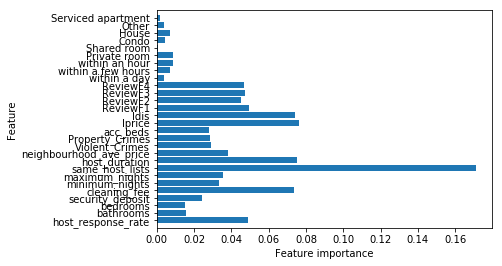

In [32]:
plot_feature_importances(forest)

From the plot above, The most improtant variable for predicting airbnb revenues is **same host lists**, which indicates how many airbnb listings are the host has. We can say that whether a list has experienced (or we can say commercial) airbnb host are more likely to effect higher revenues. Besides that, other important variables are **host durations**, **log price**, **distance to boston attractions** and **Cleaning fee**, these are also important features which can bring more profitable airbnb listings. Then after all that, customers' reveiews also show some important on revenues, based on which topic it talks about.(The reveiw vectors are result from LDA topical analysis results)

## Conclusion

In [31]:
Result = {'KNN':[KNNTrainScore.mean(),KNNTestScore.mean()],
         'Ridge':[ridgeTrainScore.mean(),ridgeTestScore.mean()],
         'Lasso':[lTrainScore.mean(),lTestScore.mean()],
         'KernelRidge':[KRTrainScore.mean(),KRTestScore.mean()],
         'BoostTree':[gbrtTrainScore.mean(),gbrtTestScore.mean()],
         'RandomForest':[forestTrainScore.mean(),forestTestScore.mean()]}
pd.DataFrame(Result,index = ['Trainset Score','Testset Score'])

,KNN,Ridge,Lasso,KernelRidge,BoostTree,RandomForest
Trainset Score,0.374583,0.209288,0.206706,0.384441,0.536995,0.854673
Testset Score,0.180022,0.181774,0.199548,0.233403,0.355787,0.380072


Unfortunately, our models all fail to provide satisfied predictability, and we are also confused about the results. After discussion, we argue that the reason might be:

1. With only about 5000 records, it is still difficult for these models to accurately fit nonlinearity in these data. Besides, large number of dummy variables and predictors makes it even harder for regression models to function well.

2. The target variable OCC or availability_90 comes from original data, which is not perfectly the ideal target variable for us, because it is much better if we can get past occupancy information in 90 days from this variable, however, without a data dictionary (the website does not seem to provide it), we can only tell this variable is an average forecast based on past data. Therefore, our result is not satisfying.

Although the output of our models are not ideal and we are unable to offer a perfect model to predict average occupancy and revenue for Airbnb listers, our work still sheds light on what an Airbnb lister can do to improve the business value of their Airbnb listing property. Here is our advice:

1. Commercialization of airbnb(**some host list**) is a major potential revenue factor for Airbnb listers. Commercial airbnb and personal airbnb listings seem to be treated differently by the market.

2. Reviews are not so crucial as what we originally thought. Listers should pay more attention on how to improve their service rather than sit there worrying about a few negative reviews.